In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.integrate
from collections import Counter
from scipy.optimize import curve_fit

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) 

In [24]:
def watershed_summary(filename, cell_size=720/320):
    f = h5py.File(filename, 'r')
    watershed = f['watershed_group'][...]
    f.close()
    counts = Counter(watershed.flatten())
    clusters = np.array(list(counts.items()))
    cluster_n_size = clusters[:,1]
    cluster_radius = (3.0*(cluster_n_size*(cell_size)**3)/(4.0*np.pi))**(1/3)
    return {'mean_radius':np.mean(cluster_radius), 'std_radius':np.std(cluster_radius), 
            'N':len(cluster_n_size), 'max_radius':np.max(cluster_radius)}

In [4]:
laniakea_vol_min = 1.7E6 # in (Mpc/h)^3
laniakea_vol_max = 2.3E6
laniakea_radius_min = (3.0*laniakea_vol_min/(4.0*np.pi))**(1/3)
laniakea_radius_max = (3.0*laniakea_vol_max/(4.0*np.pi))**(1/3)
# Numbers from https://arxiv.org/pdf/1907.06555.pdf
print(laniakea_radius_min, laniakea_radius_max)

74.0377883992306 81.88664456463073


In [5]:
#data = np.array([sigma_vals, half_r_mock, half_r_sim])
length_gauss = np.loadtxt("correlation_length_gauss.dat")
length_abacus = np.loadtxt("correlation_length_abacus.dat")
#R_s R_dd_gaussian_field R_dd_biased_tracers
print(length_gauss, length_abacus)

[[ 2.   6.5]
 [ 6.  17.3]
 [10.  27.2]
 [14.  37.5]
 [20.  51.6]] [[ 6.  14.1]
 [12.  25. ]
 [30.  46.1]
 [48.  49.3]
 [60.  36.3]]


In [25]:
ws = {}
sigmas = length_abacus[:,0]
for sigma in sigmas:
    path = "/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/"
    filename = path+"watershed_mock_AbacusCosmos_720box_planck_00_0_FoF_vmax_150.0_s_{:.1f}_nside_120.hdf5".format(sigma)
    ws['abacus_{:.2f}'.format(sigma)] = watershed_summary(filename, cell_size=720/120)

In [26]:
sigmas = length_gauss[:,0]
for sigma in sigmas:
    filename = "watershed_mock_divergence_mesh_360_box_720_slim_{:}.h5".format(int(sigma))
    ws['gauss_{:.2f}'.format(sigma)] = watershed_summary(filename, cell_size=720/320)

In [27]:
max_r_abacus = []
max_r_gauss = []

mean_r_abacus = []
mean_r_gauss = []

std_r_abacus = []
std_r_gauss = []

n_abacus = []
n_gauss = []


sigmas_gauss = length_gauss[:,0]
sigmas_abacus = length_abacus[:,0]

for sigma_gauss, sigma_abacus in zip(sigmas_gauss, sigmas_abacus):
    max_r_abacus.append(ws["abacus_{:.2f}".format(sigma_abacus)]["max_radius"])
    max_r_gauss.append(ws["gauss_{:.2f}".format(sigma_gauss)]["max_radius"])
    mean_r_abacus.append(ws["abacus_{:.2f}".format(sigma_abacus)]["mean_radius"])
    mean_r_gauss.append(ws["gauss_{:.2f}".format(sigma_gauss)]["mean_radius"])
    std_r_abacus.append(ws["abacus_{:.2f}".format(sigma_abacus)]["std_radius"])
    std_r_gauss.append(ws["gauss_{:.2f}".format(sigma_gauss)]["std_radius"])
    n_abacus.append(ws["abacus_{:.2f}".format(sigma_abacus)]["N"])
    n_gauss.append(ws["gauss_{:.2f}".format(sigma_gauss)]["N"])

max_r_abacus = np.array(max_r_abacus)
max_r_gauss = np.array(max_r_gauss)
    
mean_r_abacus = np.array(mean_r_abacus)
mean_r_gauss = np.array(mean_r_gauss)

std_r_abacus = np.array(std_r_abacus)
std_r_gauss = np.array(std_r_gauss)

n_abacus = np.array(n_abacus)
n_gauss = np.array(n_gauss)

In [28]:
def func(x, a):
    return a * x 

In [29]:
n_abacus

array([8157, 1627,  210,   78,   43])

[1.96526453] [[0.14540244]]
74.0377883992306 81.88664456463073


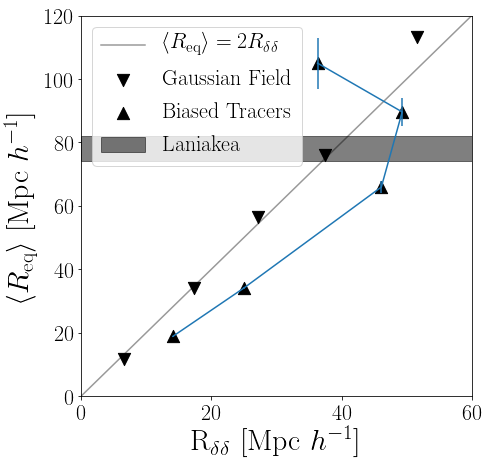

In [31]:
plt.figure(figsize=(7,7))

x = np.linspace(0,200, 100)
x_data = np.concatenate((length_gauss[:,1], length_abacus[:,1]))
y_data = np.concatenate((mean_r_gauss, mean_r_abacus))

plt.scatter(length_gauss[:,1], mean_r_gauss, 
            marker="v", s=150, label="Gaussian Field",color='black')
plt.scatter(length_abacus[:,1], mean_r_abacus, 
           marker="^", s=150, label="Biased Tracers", color='black')
plt.errorbar(length_abacus[:,1], mean_r_abacus, yerr=std_r_abacus/np.sqrt(n_abacus))

popt, pcov = curve_fit(func, x_data, y_data)

print(popt, np.sqrt(pcov))
n = '({:.2f}\pm{:.2f})'.format(popt[0], np.sqrt(pcov[0,0]))
plt.plot(x, x*2, 
         label=r'$\langle R_{\mathrm{eq}} \rangle = 2 R_{\delta\delta}$', 
        color='black', alpha=0.4)

print(laniakea_radius_min, laniakea_radius_max)
dd = np.linspace(1E-3,100)
plt.fill_between(dd, laniakea_radius_min*dd/dd, laniakea_radius_max*dd/dd, label='Laniakea', color='black', alpha=0.5)
plt.legend(loc=2, fontsize=SMALL_SIZE)
#plt.loglog()
plt.xlim(0,60)
plt.ylim(0,120)
plt.xlabel(r"R$_{\delta\delta}$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.ylabel(r"$\langle R_{\mathrm{eq}} \rangle$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.savefig("summary_scales.pdf", bbox_inches='tight')

In [21]:
filename = 'watershed_mock_divergence_mesh_360_box_720_slim_10.h5'
f = h5py.File(filename, 'r')
watershed = f['watershed_group'][...]
f.close()
counts = Counter(watershed.flatten())
clusters = np.array(list(counts.items()))
cluster_n_size = clusters[:,1]
cluster_radius_gauss = (3.0*(cluster_n_size*(720/320)**3)/(4.0*np.pi))**(1/3)

filename = 'watershed_mock_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_10.0_nside_360.hdf5'
sigma=60
path = "/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/"
filename = path+"watershed_mock_AbacusCosmos_720box_planck_00_0_FoF_vmax_150.0_s_{:.1f}_nside_120.hdf5".format(sigma)
f = h5py.File(filename, 'r')
watershed = f['watershed_group'][...]
f.close()
counts = Counter(watershed.flatten())
clusters = np.array(list(counts.items()))
cluster_n_size = clusters[:,1]
cluster_radius_abacus = (3.0*(cluster_n_size*(720/320)**3)/(4.0*np.pi))**(1/3)

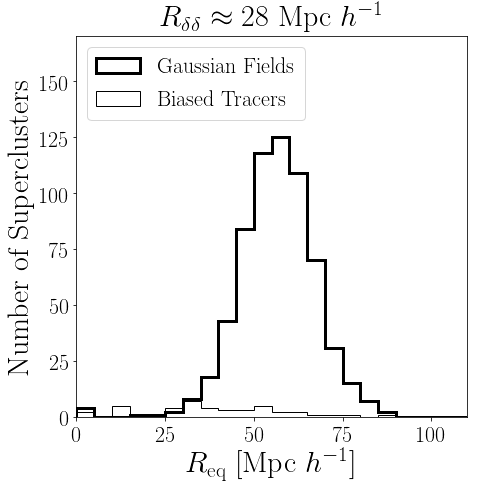

In [22]:
plt.figure(figsize=(7,7))

_ = plt.hist(cluster_radius_gauss, bins=np.arange(0,125,5), 
             color='black', histtype='step', linewidth=3, label='Gaussian Fields')
_ = plt.hist(cluster_radius_abacus, bins=np.arange(0,125,5),
             color='black', histtype='step', label='Biased Tracers')
plt.legend(loc=2, fontsize=SMALL_SIZE)
plt.xlabel(r"$R_{\mathrm{eq}}$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.ylabel(r"Number of Superclusters")
plt.title(r"$R_{\delta\delta} \approx 28\ \mathrm{Mpc}\ h^{-1}$")
plt.ylim([0,170])
plt.xlim([0,110])
plt.savefig("sizes_histogram.pdf", bbox_inches='tight')

In [23]:
cluster_radius_abacus

array([ 4.18736581, 14.18223937, 31.5017901 , 39.23753844, 12.74327926,
       35.0967697 , 32.38820023, 51.75473458, 53.47617838, 29.64019302,
       59.87665407, 43.03579798, 58.10744237, 44.76587594, 75.62954874,
       89.93094892, 47.72415797, 13.76924284, 12.74885863, 42.52266936,
       26.15806458, 39.07792635, 33.74747964, 29.74710918, 27.3131355 ,
       49.74251009, 34.06990974, 74.65706967, 62.52289212, 35.1305873 ,
       52.50422571, 34.59058173, 32.21444977, 54.54108464, 20.24197705,
       67.53532673, 62.76035965, 30.73616087, 47.74643445, 53.91224897,
        1.75858344, 18.83197067, 10.71188233])

In [ ]:
cluster_radius_abacus